# Pretrained Models and AI-based Surgical Intervention

# 1. Pretrained Models:

### NLP-based Model (Speech Recognition):

In [17]:
## Text Model:
# pip install pydub
# conda install -c conda-forge ffmpeg
# pip install SpeechRecognition
from pydub import AudioSegment
import speech_recognition as sr
import os
import librosa

def mp3_to_wav(src_filepath, dst_filepath):
    # convert wav to mp3               
    print(os.path.exists(src_filepath))
    sound = AudioSegment.from_mp3(src_filepath)
    sound.export(dst_filepath, format="wav")

def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio)
        print(f"Recognized Speech:\n\n{text}")
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e)) 


audio_to_text(audio_path="./data/audio_test.wav")

Recognized Speech:

off stage left car left my voice should be coming directly out of the left speaker midway between Center and left position exact center position in midway between Center and right position and at the right hand position


### Image-based Model:

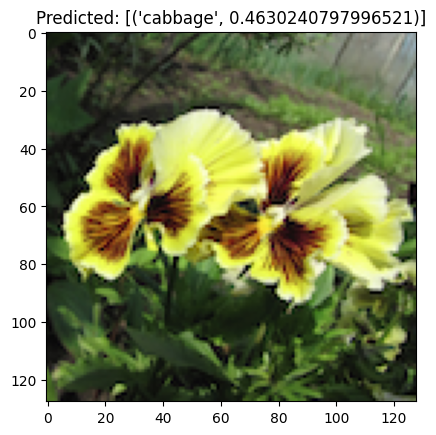

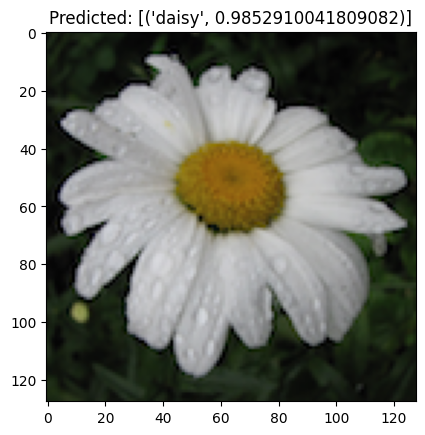

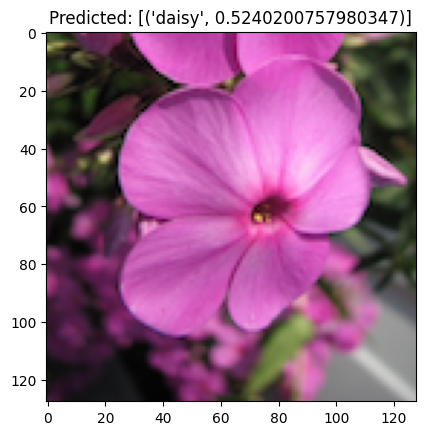

In [12]:
import os
import requests
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import random


def classify_images(image_paths, model_name='resnet18', top_k=1):
    """
    Classify a list of image paths using a pretrained image classifier.

    Parameters:
        image_paths (list of str): Paths to images to classify.
        model_name (str): Name of the pretrained model. Default is 'resnet18'.
        top_k (int): Number of top predictions to return per image.

    Returns:
        list of dict: Each entry contains image path and top-k predictions.
    """
    # Load the pretrained model
    model = getattr(models, model_name)(pretrained=True)
    model.eval()
    
    # Define image transformations
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    
    # Fetch ImageNet class labels from the URL
    url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(url)
    labels = response.json()
    
    results = []

    # Process and classify each image
    for image_path in image_paths:
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            input_tensor = preprocess(image).unsqueeze(0)

            # Make predictions
            with torch.no_grad():
                output = model(input_tensor)
                probabilities = torch.nn.functional.softmax(output[0], dim=0)
            
            # Get top-k predictions
            top_probs, top_idxs = probabilities.topk(top_k)
            top_labels = [(labels[idx], prob.item()) for idx, prob in zip(top_idxs, top_probs)]
            
            results.append({
                "image_path": image_path,
                "predictions": top_labels,
            })
        except Exception as e:
            results.append({
                "image_path": image_path,
                "error": str(e),
            })
    
    return results

def run_image_classifier(data_dir):
    # Example usage
    image_paths = [os.path.join(data_dir, filename).replace("\\", "/") for filename in os.listdir(data_dir) if (filename.endswith(".png"))]
    res = random.shuffle(image_paths)  # let's just select 10
    image_paths = image_paths[:3]  # let's just select 10
    results = classify_images(image_paths)
    for result in results:
        if "predictions" in result:
            img = Image.open(result["image_path"])
            plt.figure()
            plt.imshow(img)
            plt.title(f"Predicted: {result['predictions']}")


run_image_classifier(data_dir="./data/image")

# 2. Cutting Layer and looking inside Neural Networks: 

![alt text](assets/hidden_layers_feature_aggregation.png)

# Let's say:

* You need to collect data or you were given an unlabeled dataset.
* You want to proceed with Supervised Approach.
* Thus, you need to label the data.
    * Manually labeling data from scratch is time-consuming and costly (especially if your position a $100,000+ Data Scientist). If you spend too much time annotating data yourself manually, it won't be viewed good, since there are methods to speed this process.
    * And that is **feature embeddings**.
    * **Feature Embedding** refers to the process of transforming high-dimensional or categorical data into a lower-dimensional space, often in the form of continuous vector representations. These embeddings capture the underlying patterns or relationships in the data, which can help improve the performance of machine learning models by representing the data more effectively.
    * In machine learning, embedding techniques are commonly used for:
        * Text Data: Words or phrases are represented as vectors (word embeddings), where similar words are mapped to similar vector spaces. Examples include Word2Vec, GloVe, and FastText.
        * Categorical Data: Categories can be transformed into dense, continuous-valued vectors instead of sparse one-hot encodings, making them more useful for machine learning models.
        * Images: Deep learning models (like CNNs) can produce embeddings of images that capture the essential features, allowing for tasks like similarity search or clustering.
        * Graph Data: Nodes and edges in a graph can be embedded into vectors, allowing for better analysis of graph-based data, often using techniques like Graph Neural Networks (GNNs).

# Ok, how do I get and use that Feature Embedding?

# **SKIP TO NEXT SECTION, IGNORE THIS NLP RELATED CELL)**

# Text-based Dataset **(THIS NLP CELL NEEDS WORK - I AINT GOOD WITH NLP YET)**:
* Common pretrained model that already have good text understanding- Word2Vec

In [51]:
import os
import re
import string
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
import plotly.express as px


# 1. Preprocess the text data
def preprocess_text(text):
    # Lowercase, remove punctuation, and tokenize
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    # Remove stopwords (add a stopword list if needed)
    stopwords = set(["the", "and", "is", "in", "to", "of", "a", "for", "on"])
    words = [word for word in words if word not in stopwords]
    return words


def visualize_text_data_after_autoAnnotation(data_dir, word2vec_model):    
    # 2. Collect data:
    features = []
    labels = []
    for filename in os.listdir(data_dir):
        if ".ipynb_checkpoints" in filename:
            continue
        filepath = os.path.join(data_dir, filename)
        class_name = filename.split("_")[1]
        with open(filepath, "r") as file_data:
            text_data = file_data.readlines()
            text_embedding = get_document_embedding(text_data, word2vec_model)
            features.append(text_embedding)
            labels.append(class_name)

    features = np.array(features )
    labels = np.array(labels)

    # 3. Setup UMAP and visualize features:    
    projection_model = TSNE(n_components=3, random_state=0)  # UMAP(n_components=3, init='random', random_state=0)
    projections = projection_model.fit_transform(features,)
    
    fig = px.scatter_3d(
        projections, x=0, y=1, z=2,
        color=labels  # , labels={'color': 'species'}
    )
    fig.update_traces(marker_size=8)
    fig.show()

def cluster_embeddings(embeddings, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
    labels = dbscan.fit_predict(embeddings)
    return labels

def get_document_embedding(document, model):
        # Average the Word2Vec vectors for all words in the document
        vectors = [model.wv[word] for word in document if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

def main_noLabel_textDataset_Annotation(data_dir, n_clusters):
    # 1. Load dataset
    documents = []
    df_row_numbers = []

    data_df = pd.read_csv(os.path.join(data_dir, "text_based_dataset.csv"))  # "your_text_data_folder"
    for index, row in data_df.iterrows():
        documents.append(row["Text"])
        df_row_numbers.append(index)
    print(">>> Step 1 is completed.")
    
    # 2. Initialize Word2Vec model
    word2vec_model = Word2Vec(sentences=documents, vector_size=512, window=5, min_count=1, workers=4)
    print(">>> Step 2 is completed.")
    
    # 3. Generate document embeddings
    # def get_document_embedding(document, model):
    
    document_embeddings = np.array([get_document_embedding(doc, word2vec_model) for doc in documents])
    print(">>> Step 3 is completed.")
    
    # 4. Cluster documents
    n_clusters = n_clusters  # Adjust the number of clusters as needed
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(document_embeddings)
    print(">>> Step 4 is completed.")
    
    # 5. Save documents by cluster
    output_dir = os.path.join(data_dir, "text_clustered_articles")
    os.makedirs(output_dir, exist_ok=True)
    
    for i, cluster_label in enumerate(cluster_labels):
        cluster_file = os.path.join(output_dir, f"class_{cluster_label}_{i}.txt")
        with open(cluster_file, "w", encoding="utf-8") as f:
            f.write(f"Original Row from dataframe: {df_row_numbers[i]}\n\n\n")  # Optional: Save file names
            f.write(documents[i])
    print(">>> Step 5 is completed.")
    print(">>> Automatic Annotation has finished.")

    visualize_text_data_after_autoAnnotation(output_dir, word2vec_model)


main_noLabel_textDataset_Annotation(data_dir="./data/text", n_clusters=5)

>>> Step 1 is completed.
>>> Step 2 is completed.
>>> Step 3 is completed.
>>> Step 4 is completed.
>>> Step 5 is completed.
>>> Automatic Annotation has finished.


# Image Based Embeddings and Automated Annotation:

In [52]:
import os
import shutil
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
import plotly.express as px


def visualize_image_data_after_autoAnnotation(features, labels):    
    features = np.array(features )
    labels = np.array(labels)

    # 3. Setup UMAP and visualize features:    
    projection_model = TSNE(n_components=3, random_state=0)  # UMAP(n_components=3, init='random', random_state=0)
    projections = projection_model.fit_transform(features,)
    
    fig = px.scatter_3d(
        projections, x=0, y=1, z=2,
        color=labels  # , labels={'color': 'species'}
    )
    fig.update_traces(marker_size=8)
    fig.show()


# 1. Load and preprocess images
def load_images(image_folder, image_size=(224, 224)):
    images = []
    file_paths = []

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for file_name in filter(lambda f: os.path.isfile(os.path.join(image_folder, f)), os.listdir(image_folder)):
        file_path = os.path.join(image_folder, file_name)
        try:
            img = Image.open(file_path).convert("RGB")
            img = transform(img)
            images.append(img)
            file_paths.append(file_path)
        except Exception as e:
            print(f"Could not process image {file_name}: {e}")

    return images, file_paths

# 2. Extract embeddings using ResNet
def extract_embeddings(images, model):
    embeddings = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0)  # Add batch dimension
            feature_map = model(img)  # Get 4D feature map
            embedding = feature_map.view(-1).numpy()  # Flatten to 1D
            embeddings.append(embedding)
    return np.array(embeddings)

# 3. Cluster images
def cluster_embeddings(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

# 4. Save images by cluster
def save_clustered_images(file_paths, labels, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for i, label in enumerate(labels):
        cluster_folder = os.path.join(output_folder, f"class_{label}")
        os.makedirs(cluster_folder, exist_ok=True)
        shutil.copy(file_paths[i], cluster_folder)


def prepare_annotation_for_images(data_dir, n_clusters):
    # Main script
    image_folder = data_dir  # Path to the folder with images
    output_folder = os.path.join(data_dir, "clustered_images")  # Path to save clustered images
    n_clusters = n_clusters  # Adjust number of clusters as needed
    
    # Load images
    images, file_paths = load_images(image_folder)
    
    # Load pretrained ResNet model and remove classification head
    resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    model = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification head
    
    # Extract embeddings
    embeddings = extract_embeddings(images, model)
    
    # Cluster images
    labels = cluster_embeddings(embeddings, n_clusters)
    
    # Save clustered images
    save_clustered_images(file_paths, labels, output_folder)

    visualize_image_data_after_autoAnnotation(embeddings, labels)

In [53]:
prepare_annotation_for_images(data_dir="./data/image", n_clusters=5)

# Audio Based Embeddings and Automated Annotation:

In [54]:
import os
import shutil
import librosa
import numpy as np
from sklearn.cluster import KMeans
import torch
import torchvision.models as models
from torchvision.models import VGG16_Weights
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
import plotly.express as px
import matplotlib.pyplot as plt


def visualize_image_data_after_autoAnnotation(features, labels):    
    features = np.array(features )
    labels = np.array(labels)

    # 3. Setup UMAP and visualize features:    
    projection_model = TSNE(n_components=3, random_state=0)  # UMAP(n_components=3, init='random', random_state=0)
    projections = projection_model.fit_transform(features,)
    
    fig = px.scatter_3d(
        projections, x=0, y=1, z=2,
        color=labels  # , labels={'color': 'species'}
    )
    fig.update_traces(marker_size=8)
    fig.show()


# 1. Load and preprocess audio
def load_audio_files(audio_folder, sample_rate=16000, duration=5):
    audio_clips = []
    file_paths = []

    for file_name in os.listdir(audio_folder):
        file_path = os.path.join(audio_folder, file_name)
        if not os.path.isfile(file_path):
            continue
        try:
            # Load audio with librosa
            audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
            # Pad or truncate to fixed length
            audio = librosa.util.fix_length(audio, size=sample_rate * duration)
            audio_clips.append(audio)
            file_paths.append(file_path)
        except Exception as e:
            print(f"Could not process audio {file_name}: {e}")

    return audio_clips, file_paths

# 2. Extract embeddings using VGGish
def extract_audio_embeddings(audio_clips, model, sample_rate=16000):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for audio in audio_clips:
            # Convert audio to spectrogram
            spectrogram = librosa.feature.melspectrogram(
                y=audio, sr=sample_rate, n_mels=128, fmax=8000
            )
            log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

            # Convert spectrogram to tensor and repeat channels
            spectrogram_tensor = torch.tensor(log_spectrogram).unsqueeze(0)
            spectrogram_tensor = spectrogram_tensor.repeat(3, 1, 1)  # Repeat along channel dimension
            spectrogram_tensor = spectrogram_tensor.unsqueeze(0)  # Add batch dimension
            spectrogram_tensor = spectrogram_tensor.type(torch.FloatTensor)

            # Extract features with VGGish
            embedding = model(spectrogram_tensor).squeeze(0).numpy()
            embeddings.append(embedding.flatten())

        plt.figure()
        plt.imshow(log_spectrogram)
        plt.title("Sample Spectrogram (Audio Visualization)")

    return np.array(embeddings)


# 3. Cluster audio embeddings
def cluster_audio_embeddings(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

# 4. Save audio files by cluster
def save_clustered_audio(file_paths, labels, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for i, label in enumerate(labels):
        cluster_folder = os.path.join(output_folder, f"class_{label}")
        os.makedirs(cluster_folder, exist_ok=True)
        shutil.copy(file_paths[i], cluster_folder)


def prepare_annotation_for_audio(data_dir, n_clusters):
    # Main script
    audio_folder = data_dir  # Path to the folder with audio files
    output_folder = os.path.join(data_dir, "clustered_audio")  # Path to save clustered audio
    n_clusters = n_clusters  # Adjust number of clusters as needed
    
    # Load audio files
    audio_clips, file_paths = load_audio_files(audio_folder)
    
    # Load pretrained VGGish model
    vggish = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    vggish.classifier = torch.nn.Sequential(*list(vggish.classifier.children())[:-1])  # Remove classification head
    
    # Extract embeddings
    embeddings = extract_audio_embeddings(audio_clips, vggish)
    
    # Cluster audio files
    labels = cluster_audio_embeddings(embeddings, n_clusters)
    
    # Save clustered audio files
    save_clustered_audio(file_paths, labels, output_folder)

    visualize_image_data_after_autoAnnotation(embeddings, labels)

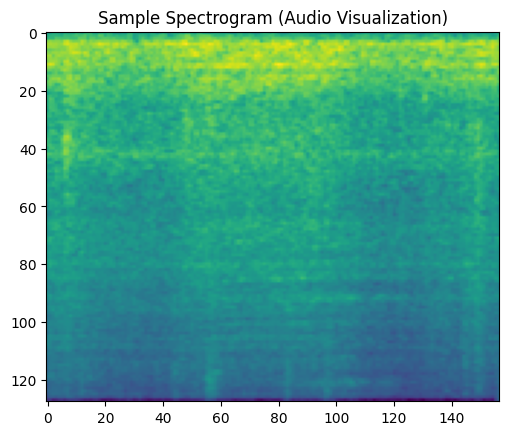

In [56]:
prepare_annotation_for_audio(data_dir="./data/audio", n_clusters=5)